# How to use kmcluster

Here is a quick set of examples showing how (and why) to use the ```kmcluster``` package.

In [1]:
from kmcluster import KMeans_and_Cluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
pd.set_option('max_rows',10)

Our sample data will be the "moons" dataset, which looks like this:

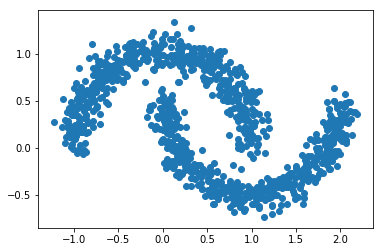

In [2]:
moons = make_moons(n_samples=1000, shuffle=True, noise=0.1)
# moons[0] is an (n,2) numpy array of coordinates, moons[1] labels the points as being in moon 0 or moon 1
plt.scatter(x=moons[0][:,0], y=moons[0][:,1])

Feed the data into ```KMeans_and_Cluster```:

In [3]:
K = KMeans_and_Cluster(moons[0])

This should usually be pretty quick--the most expensive part of instantiating ```K``` is computing the ```pdist``` array of pairwise distances (from ```scipy.spatial.distance```).

If desired, we can filter out outliers by using the ```prefilter``` method (this can also be combined with the input step by passing ```prefilter=dist``` to the constructor in the step above). This will tag any points that are at least a distance of ```dist``` away from all other points in the dataset with ```include=False``` in the ```points``` DataFrame inside ```K```.

In [4]:
K.prefilter(0.1)

This only takes a moment for 1000 points, but in general it's a O(n^2) operation for n points, since (in the current version, at least) it involves looping over the array of pairwise distances. However, since only the first call of ```prefilter``` has to compute the minimum distance from each point to any other point in the dataset, future calls are much faster.

To see the result, we can produce a scatterplot with ```hue='include'``` to distinguish between core points and outliers:

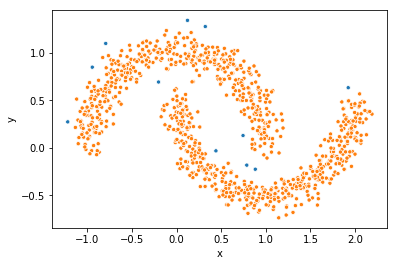

In [5]:
K.scatter_plot(hue='include')

Note that, until I can figure out how to get Seaborn to play nicely with legends, no legend is included. You can still set the legend manually, since the axis object is returned by ```scatter_plot```.

Next, we use k-means clustering (```sklearn.cluster.KMeans```) to break the data into a large number of chunks. This is the slowest step, since in addition to calling ```KMeans```, we are also computing the distances between all of the resulting chunks.

In [6]:
K.chunkify(40)

By default, nothing is returned, though you can specify ```output='dataframe'``` or ```output='arrays'``` to get a DataFrame or tuple of numpy arrays back, if desired.

As with ```prefilter```, this takes only a few moments for 1000 points, but significantly longer for, say, 10000. In the future, ```chunkify``` may include a ```verbose``` option to show whether ```KMeans``` is finished and how many chunk distances have been computed.

Calling ```scatter_plot``` with ```hue='chunk'``` shows the result (note that now, outliers are not shown at all):

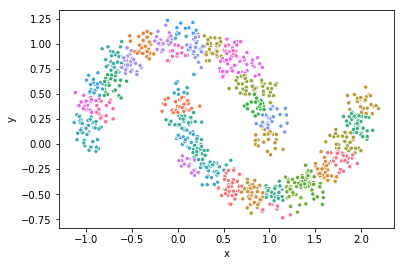

In [7]:
K.scatter_plot(hue='chunk')

Finally, we can agglomerate the chunks into clusters using ```clusterify```. This is very fast, since all the nontrivial computations are already done. If you don't like the results of your first run of ```clusterify```, you can just run it again with a different (higher or lower) number of clusters. Since this is theoretically the final result a user is looking for, ```clusterify``` returns the data with cluster labels in a DataFrame by default (you can get the result as a tuple of numpy arrays or suppress it entirely with ```output='arrays'``` or ```output=None```, respectively). 

In [8]:
K.clusterify(2)

,x,y,cluster
0,1.774835,-0.085965,0.0
1,0.673703,-0.300827,0.0
2,-0.158081,0.402601,0.0
3,-0.320254,0.946543,3.0
4,1.636440,-0.257200,0.0
...,...,...,...
995,-1.060840,0.141470,3.0
996,0.224546,0.816786,3.0
997,0.487213,0.725055,3.0
998,0.635574,0.880567,3.0


Since ```hue=cluster``` is the default argument for ```scatter_plot```, we can call that method without argument to see the final result of ```KMeans_and_Cluster```:

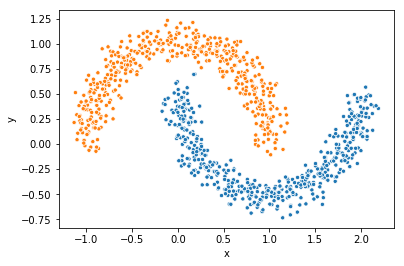

In [9]:
K.scatter_plot()

Visually, this definitely seems to have done the job. We can also check our work by extracting the points and their labels using the ```get_points``` method, which takes any of the attribute columns discussed so far (```'include'```, ```'chunk'```, ```'cluster'```, ```'min_distance'```) and an optional ```output``` argument which again defaults to ```'dataframe'```: 

In [10]:
pts_arrays = K.get_points('include','cluster', output='arrays')
# returns a tuple of numpy arrays: ((n,2)-shaped array of xy-coords, include labels, cluster labels)

from sklearn.metrics import adjusted_rand_score
# ARS compares two clusterings based on which pairs of points in each clustering have the same label
# random chance yields score of ~0, perfect is 1
# true labels are +/- 1 in moons[1]

adjusted_rand_score(moons[1],pts_arrays[2])

0.9702255457702427

Since adjusted Rand score effectively double-counts errors, the 97% score above means there were 0.5 x 0.03 x 1000 = 15 labeling errors, counting outliers as wrong. There are only 11 outliers (see cell below, or just count them in the first scatterplot), so this method labeled 4 points out of 1000 wrong when it was actually trying.

In [11]:
K.get_points('include').include.value_counts()

True     989
False     11
Name: include, dtype: int64